In [4]:
%load_ext autoreload
%autoreload 2

*Authors: Ema Donev and dr. Ivezić*

In this notebook we tackle the portion of our stars which are RR Lyraes. We conduct extensive light curve analysis, starting from period calculation using the Lomb-Scargle periodogram. We also calculate the ratio of periods between LINEAR and ZTF, as well as the mean period used later for analysis. From the periodogram we conduct additional analysis of local peak indication of the Blazhko effect. We also fit light curves based on their period and save statistical metrics such as chi2 and rms. We use this data later for BE candidate analysis.

In [5]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML
from astroML.datasets import fetch_LINEAR_sample
from astropy.coordinates import SkyCoord
import astropy.units as u

# Basic libraries
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm

# CONFIGURATION
# -------------
sns.set_theme() # setting the theme for plotting
sys.path.insert(0,'../src/')
np.random.seed(42)

# configuring plotting colors
colors = ['#5F6372', '#79A8A4', '#B2AD8F', '#92A186', '#AD8082']
blue = '#5F6372'
turqoise = '#79A8A4'
light_green = '#B2AD8F'
green = '#92A186'
pink = '#AD8082'
muted_colors = sns.set_palette(sns.color_palette(colors))

# configuring fonts for plotting
font = FontProperties()
font.set_family('avenir')
font.set_name('Big Caslon')
font.set_style('normal')
font.set_size('xx-large')


%matplotlib inline  

In [6]:
sys.path.insert(0,'../src/')
import blazhko_analysis
import BE_plotting
import helper
import RR_lyrae_params
import data_access

In [7]:
#| code-fold: false
# LINEAR DATA
dataL = fetch_LINEAR_sample(data_home='../inputs') # fetching the data from astroML data library

# Methods used for analysis of RR Lyrae light curves

### Period determination

The Lomb-Scargle method of computing the period of a variable star using light curves involves fitting multi-level sinusoidal waves to our light curve data over various trial periods, and the period with the most prominent strength or the best fit is the actual period.

This is the formula for the Lomb-Scargle periodogram:

$$P(ω)= \frac{1}{2σ^2}​*(\frac{[∑y_k cosω(t_k−τ)]^2}{∑cos^2 ω(t_k−τ)} + \frac{[∑y_k sin ω(t_k−τ)]^2}{∑ sin^2 ω(t_k−τ)})$$

We use the Lomb-Scargle periodogram because it is the most famous tool for determining the periodic variable stars' period. It combines multiple methods of analysis, with its core being in Fourier analysis, and it operates with non-uniformly spaced data, such is the nature of light curves.

### Light curve folding

**Light curve phasing or folding** is when we condense the entire timeseries of the light curve into one *phase*, or one cycle of variability. Phase is defined with the period of the light curve, as such: $$phase = \frac{time}{period} - int(\frac{time}{period})$$ This function defines the period as a value from 0 to 1 defining how far in is the star in its variability cycle. We can then adjust the `time` array using this function.

### Fitting light curves
**Light curve fitting** requires a sophisticated function which uses Fourier analysis to correctly fit a curve through light curve `time`, `mag` and `magerr` data. We can define how many terms we want our fit to have. *The more terms we use, the more complicated shapes we can graph*. The fitting is an essential part of light curve analysis, as we can then calculate the goodness of fit and monitor how that fit changes over long periods of time, like in the case of `LINEAR` and `ZTF`.

### `Chi-2 test` and `RMS scatter`

#### `RMS scatter`
RMS scatter is a statistical metric that, in this case, measures the goodness of fit versus the actuall data. It is calculated as such: $$RMS = \sqrt{\frac{1}{n}\sum^n_{i=1} x_i^2}$$

#### `Chi-2 test`
This test asseses the "goodness of fit" of light curves, by comparing the fitted values and the actual magnitude values of the light curve. The lower the chi-2 value, the better the correlation between the observed and expected values (based on some model), and the higher the chi-2 value, the poorer the correlation. At which point the value is too high or too low is determined by the statistician, based on the degrees of freedom and the nature of the data. The chi-2 value for every point of a light curve is calculated as such: $$\chi^2 = \sum{\frac{(O_i - E_i)^2}{E_i}}$$

### Periodogram analysis

As a final step of the RR Lyrae analysis process, we need to analyze the periodograms which the Lomb-Scargle method produces. A periodogram is a plot of the power of each frequency, telling us which frequency, or period, fits the light curve best. We can use this periodogram to look for signs of the Blazhko Effect: if there are 2 subsequent local peaks around the maximum, the star is likely a BE star. 

We determine the existence of local peaks by folding the periodogram by the maximum peak, multiplying each folded part to amplify signals so they are easier to detect, and we then search for the next strongest peak. Our program also calculates the 1-year anomaly, making sure that we really find the correct frequencies.

# Analysis of RR Lyrae stars

### Importing data

In [8]:
Lrrlyr = pd.read_csv('../outputs/Lrrlyr_unprocessed.csv')
end = 'FINAL_complete'
dataZTF = np.load("../outputs/ZTF_dataset_"+end+".npy", allow_pickle=True)

In [9]:
#| code-fold: false
# CONFIG BEFORE BIG RUN

Lids = Lrrlyr['ID'].to_numpy()
lc_type = Lrrlyr['LCtype'].to_numpy()
rectascension = Lrrlyr['ra'].to_numpy() # list of rectascension coordinates
declination = Lrrlyr['dec'].to_numpy() # list of declination coordinates

end = 'FINAL_complete'

In [13]:
test = len(Lids)
ZTF_data_best = []
periodograms = []
lc_analysis = {}
fits = []

if os.path.isfile('../outputs/LC_ANALYSIS_FINAL_complete.csv'):
    print('Loading data!')
    LC_ANALYSIS = pd.read_csv('../outputs/LC_ANALYSIS_'+end+'.csv')
    periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
    fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
    ztfdata = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)

"""
else:
    for i in tqdm(range(test)):
        Lid = Lids[i]
        datalinear = dataL.get_light_curve(Lid)
        for j in dataZTF:
            if j[0]==Lid:
                dataZ = j[1]
        
        if datalinear.T[0].shape[0]>250 and dataZ.shape[0]>250:
            lc_analysis, periodograms, fits, ZTF_data_best = RR_lyrae_params.RR_lyrae_analysis(end, i, Lid, datalinear, dataZ, lc_analysis, ZTF_data_best, fits, periodograms)
        else:
            continue
        
        if i%10==0:
            # save dictionary to pkl file
            with open('../outputs/lc_analysis_'+end+'.pkl', 'wb') as fp:
                pickle.dump(lc_analysis, fp)
            with open("../outputs/periodograms_"+end+".pkl", "wb") as x:
                pickle.dump(periodograms, x)
            FITS = np.array(fits, dtype=object)
            np.save("../outputs/fits_"+end+".npy", FITS, allow_pickle=True)
            ZTF_data_lca = np.array(ZTF_data_best, dtype=object)
            np.save("../outputs/ztf_data_filter"+end+".npy", ZTF_data_lca, allow_pickle=True)
            
    # save dictionary to pkl file
    with open('../outputs/lc_analysis_'+end+'.pkl', 'wb') as fp:
        pickle.dump(lc_analysis, fp)
    with open("../outputs/periodograms_"+end+".pkl", "wb") as x:
        pickle.dump(periodograms, x)
    FITS = np.array(fits, dtype=object)
    np.save("../outputs/fits_"+end+".npy", FITS, allow_pickle=True)
    ZTF_data_lca = np.array(ZTF_data_best, dtype=object)
    np.save("../outputs/ztf_data_filter"+end+".npy", ZTF_data_lca, allow_pickle=True)
"""

Loading data!


'\nelse:\n    for i in tqdm(range(test)):\n        Lid = Lids[i]\n        datalinear = dataL.get_light_curve(Lid)\n        for j in dataZTF:\n            if j[0]==Lid:\n                dataZ = j[1]\n        \n        if datalinear.T[0].shape[0]>250 and dataZ.shape[0]>250:\n            lc_analysis, periodograms, fits, ZTF_data_best = RR_lyrae_params.RR_lyrae_analysis(end, i, Lid, datalinear, dataZ, lc_analysis, ZTF_data_best, fits, periodograms)\n        else:\n            continue\n        \n        if i%10==0:\n            # save dictionary to pkl file\n            with open(\'../outputs/lc_analysis_\'+end+\'.pkl\', \'wb\') as fp:\n                pickle.dump(lc_analysis, fp)\n            with open("../outputs/periodograms_"+end+".pkl", "wb") as x:\n                pickle.dump(periodograms, x)\n            FITS = np.array(fits, dtype=object)\n            np.save("../outputs/fits_"+end+".npy", FITS, allow_pickle=True)\n            ZTF_data_lca = np.array(ZTF_data_best, dtype=object)\n 

In [26]:
for i in tqdm(range(3)):
        Lid = Lids[i]
        datalinear = dataL.get_light_curve(Lid)
        for j in dataZTF:
            if j[0]==Lid:
                dataZ = j[1]
        
        if datalinear.T[0].shape[0]>250 and dataZ.shape[0]>250:
            lctest, prtest, ftest, ztftest = RR_lyrae_params.RR_lyrae_analysis(end, i, Lid, datalinear, dataZ, lc_analysis, ZTF_data_best, fits, periodograms)
        else:
            continue

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:17<00:35, 17.95s/it]


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [25]:
cols = ['Plinear', 'Pztf', 'Pmean', 'Pratio', 'NdataLINEAR', 
        'L_rms', 'L_chi2dof', 'L_chi2dofR',
            'Lmean_rms', 'Lmean_chi2dof', 'Lmean_chi2dofR', 'Lmmax', 'Lampl',
         'NdataZTF', 'Z_rms', 'Zchi2dof',
            'Zchi2dofR', 'Zmean_rms', 'Zmean_chi2dof', 'Zmean_chi2dofR',
            'Zmmax', 'Zampl',
            'MainPeakL', 'BlazhkoPeakL', 'BlazhkoPeriodL','BpowerRatioL','BsignificanceL',
            'MainPeakZ', 'BlazhkoPeakZ', 'BlazhkoPeriodZ', 'BpowerRatioZ', 'BsignificanceZ']
lctest = pd.DataFrame.from_dict(lctest, orient='index', columns=cols)
lctest.index.name='LINEAR id'
#lctest = lctest.drop([\"what\"], axis=1)
#lctest = lctest.drop([\"what 2\"], axis=1)
lctest = lctest.reset_index()

NameError: name 'lctest' is not defined

In [10]:
cols = ['Plinear', 'Pztf', 'Pmean', 'Pratio', 'NdataLINEAR', 
        'L_rms', 'L_chi2dof', 'L_chi2dofR',
            'Lmean_rms', 'Lmean_chi2dof', 'Lmean_chi2dofR', 'Lmmax', 'Lampl',
         'NdataZTF', 'Z_rms', 'Zchi2dof',
            'Zchi2dofR', 'Zmean_rms', 'Zmean_chi2dof', 'Zmean_chi2dofR',
            'Zmmax', 'Zampl',
            'MainPeakL', 'BlazhkoPeakL', 'BlazhkoPeriodL','BpowerRatioL','BsignificanceL',
            'MainPeakZ', 'BlazhkoPeakZ', 'BlazhkoPeriodZ', 'BpowerRatioZ', 'BsignificanceZ']
LC_ANALYSIS = pd.DataFrame.from_dict(lc_analysis, orient='index', columns=cols)
LC_ANALYSIS.index.name='LINEAR id'
#LC_ANALYSIS = LC_ANALYSIS.drop([\"what\"], axis=1)
#LC_ANALYSIS = LC_ANALYSIS.drop([\"what 2\"], axis=1)
LC_ANALYSIS = LC_ANALYSIS.reset_index()
LC_ANALYSIS.to_csv("../outputs/LC_ANALYSIS_"+end+".csv", index=False)

In [22]:
LC_ANALYSIS = pd.read_csv("../outputs/LC_ANALYSIS_"+end+".csv")

LC_ANALYSIS['MainPeakL'] = pd.to_numeric(LC_ANALYSIS['MainPeakL'], errors='coerce').fillna(0)
LC_ANALYSIS['BlazhkoPeakL'] = pd.to_numeric(LC_ANALYSIS['BlazhkoPeakL'], errors='coerce').fillna(0)
LC_ANALYSIS['BlazhkoPeriodL'] = pd.to_numeric(LC_ANALYSIS['BlazhkoPeriodL'], errors='coerce').fillna(0)
LC_ANALYSIS['BpowerRatioL'] = pd.to_numeric(LC_ANALYSIS['BpowerRatioL'], errors='coerce').fillna(0)
LC_ANALYSIS['BsignificanceL'] = pd.to_numeric(LC_ANALYSIS['BsignificanceL'], errors='coerce').fillna(0)
LC_ANALYSIS['MainPeakZ'] = pd.to_numeric(LC_ANALYSIS['MainPeakZ'], errors='coerce').fillna(0)
LC_ANALYSIS['BlazhkoPeakZ'] = pd.to_numeric(LC_ANALYSIS['BlazhkoPeakZ'], errors='coerce').fillna(0)
LC_ANALYSIS['BlazhkoPeriodZ'] = pd.to_numeric(LC_ANALYSIS['BlazhkoPeriodZ'], errors='coerce').fillna(0)
LC_ANALYSIS['BpowerRatioZ'] = pd.to_numeric(LC_ANALYSIS['BpowerRatioZ'], errors='coerce').fillna(0)
LC_ANALYSIS['BsignificanceZ'] = pd.to_numeric(LC_ANALYSIS['BsignificanceZ'], errors='coerce').fillna(0)

LC_ANALYSIS['Pratio'] = round(LC_ANALYSIS['Pratio'], 6)
LC_ANALYSIS['Plinear'] = round(LC_ANALYSIS['Plinear'], 6)
LC_ANALYSIS['Pztf'] = round(LC_ANALYSIS['Pztf'], 6)
LC_ANALYSIS["Pmean"] = round(LC_ANALYSIS["Pmean"], 6)
LC_ANALYSIS['Lampl'] = round(LC_ANALYSIS['Lampl'], 2)
LC_ANALYSIS['Zampl'] = round(LC_ANALYSIS['Zampl'], 2)
LC_ANALYSIS['L_chi2dofR'] = round(LC_ANALYSIS['L_chi2dofR'], 1)
LC_ANALYSIS['Lmean_chi2dofR'] = round(LC_ANALYSIS['Lmean_chi2dofR'], 1)
LC_ANALYSIS['Zchi2dofR'] = round(LC_ANALYSIS['Zchi2dofR'], 1)
LC_ANALYSIS['Zmean_chi2dofR'] = round(LC_ANALYSIS['Zmean_chi2dofR'], 1)
LC_ANALYSIS['L_chi2dof'] = round(LC_ANALYSIS['L_chi2dof'], 1)
LC_ANALYSIS['Lmean_chi2dof'] = round(LC_ANALYSIS['Lmean_chi2dof'], 1)
LC_ANALYSIS['Zchi2dof'] = round(LC_ANALYSIS['Zchi2dof'], 1)
LC_ANALYSIS['Zmean_chi2dof'] = round(LC_ANALYSIS['Zmean_chi2dof'], 1)
LC_ANALYSIS['Ampl_diff'] = round(abs(LC_ANALYSIS['Lampl'] - LC_ANALYSIS['Zampl']), 2)
LC_ANALYSIS['dP'] = round(abs((LC_ANALYSIS['Plinear']-LC_ANALYSIS['Pztf'])/LC_ANALYSIS['Pmean']),5)
LC_ANALYSIS['MainPeakL'] = round(LC_ANALYSIS['MainPeakL'], 4)
LC_ANALYSIS['BlazhkoPeakL'] =round(LC_ANALYSIS['BlazhkoPeakL'], 4)
LC_ANALYSIS['BlazhkoPeriodL'] = round(LC_ANALYSIS['BlazhkoPeriodL'], 4)
LC_ANALYSIS['BpowerRatioL'] = round(LC_ANALYSIS['BpowerRatioL'], 4)
LC_ANALYSIS['BsignificanceL'] = round(LC_ANALYSIS['BsignificanceL'], 4)
LC_ANALYSIS['MainPeakZ'] = round(LC_ANALYSIS['MainPeakZ'], 4)
LC_ANALYSIS['BlazhkoPeakZ'] = round(LC_ANALYSIS['BlazhkoPeakZ'], 4)
LC_ANALYSIS['BlazhkoPeriodZ'] = round(LC_ANALYSIS['BlazhkoPeriodZ'], 4)
LC_ANALYSIS['BpowerRatioZ'] = round(LC_ANALYSIS['BpowerRatioZ'], 4)
LC_ANALYSIS['BsignificanceZ'] = round(LC_ANALYSIS['BsignificanceZ'], 4)
LC_ANALYSIS['LCtype'] = Lrrlyr['LCtype']
LC_ANALYSIS['IndicatorType'] = 'NaN'
LC_ANALYSIS['ChiType'] = 'NaN'
LC_ANALYSIS['BE_score'] = 'NaN'

LC_ANALYSIS.to_csv('../outputs/LC_ANALYSIS_FINAL_complete.csv', index=False)
periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
ztf_data = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)

In [23]:
LC_ANALYSIS.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_rms,L_chi2dof,L_chi2dofR,Lmean_rms,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,LCtype,IndicatorType,ChiType,BE_score
0,50402,0.643303,0.643294,0.6433,1.0000,284,0.105976,0.6,0.7,0.107611,...,1.9160,295.8580,0.0149,2.2053,0.10,0.00001,1,NaN,NaN,NaN
1,62892,0.530776,0.530785,0.5308,1.0000,276,0.108535,1.1,0.9,0.131104,...,1.9434,16.8265,0.0291,4.9825,0.20,0.00002,1,NaN,NaN,NaN
2,136668,0.532923,0.532929,0.5329,1.0000,310,0.123066,1.6,1.1,0.151065,...,1.9396,15.8403,0.0801,8.7778,0.15,0.00001,1,NaN,NaN,NaN
3,141414,0.335690,0.335669,0.3357,0.9999,278,0.119125,0.6,0.8,0.180636,...,1.4928,306.2787,0.0211,4.7280,0.10,0.00006,1,NaN,NaN,NaN
4,142794,0.470787,0.470802,0.4708,1.0000,270,0.095003,1.8,1.0,0.116360,...,2.1851,16.3626,0.0286,6.0733,0.00,0.00003,2,NaN,NaN,NaN


# Statistical analysis of data

Before we continue with BE analysis, let's analyse now both `LINEAR` and `ZTF` data.

### Datapoints statistics

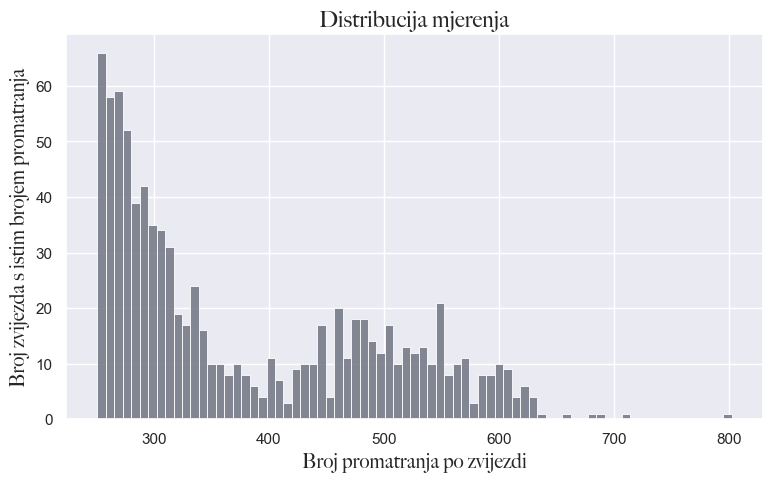

In [14]:
plt.figure(figsize=(9,5))
sns.histplot(data=LC_ANALYSIS['NdataLINEAR'].to_numpy(),color=blue, bins=75) # drawing a histogram of the distribution of measurements
plt.title('Distribucija mjerenja', fontproperties=font,fontsize=16)
plt.xlabel('Broj promatranja po zvijezdi', fontproperties=font, fontsize=14)
plt.ylabel('Broj zvijezda s istim brojem promatranja', fontproperties=font,fontsize=14)
plt.savefig('../images/LINEAR_observations_distribution_rrlyrae.png', dpi=650)
plt.show()

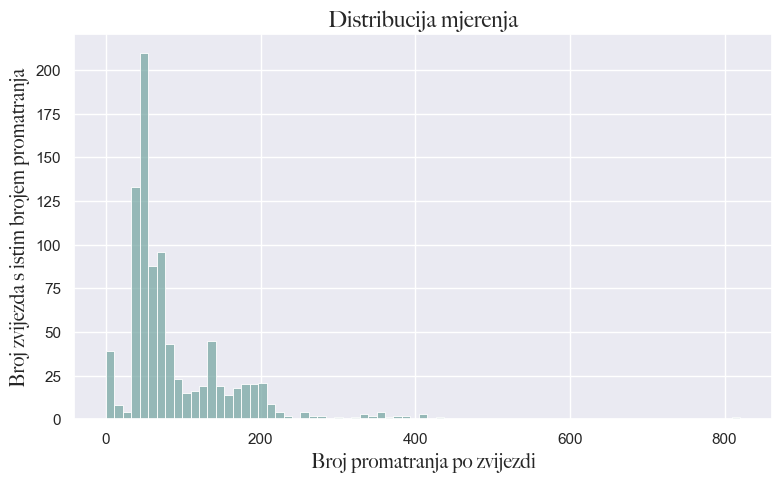

In [15]:
plt.figure(figsize=(9,5))
sns.histplot(data=LC_ANALYSIS['NdataZTF'].to_numpy(),color=turqoise, bins=75) # drawing a histogram of the distribution of measurements
plt.title('Distribucija mjerenja', fontproperties=font,fontsize=16)
plt.xlabel('Broj promatranja po zvijezdi', fontproperties=font, fontsize=14)
plt.ylabel('Broj zvijezda s istim brojem promatranja', fontproperties=font,fontsize=14)
plt.savefig('../images/ZTF_observations_distribution_rrlyrae.png', dpi=650)
plt.show()

We can see that `LINEAR` contains more datapoints per star than `ZTF` does, and we have stars with less than 250 datapoints since `ZTF` contains data for 3 filters, and here we show data for the one filter that got chosen for analysis in our previous function, so most of these will not even be candidates due to their size. 

In [18]:
LC_ANALYSIS.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_rms,L_chi2dof,L_chi2dofR,Lmean_rms,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,LCtype,IndicatorType,ChiType,BE_score
0,50402,0.643303,0.643294,0.6433,1.0000,284,0.105976,0.6,0.7,0.107611,...,1.9160,295.8580,0.0149,2.2053,0.10,0.00001,1,NaN,NaN,NaN
1,62892,0.530776,0.530785,0.5308,1.0000,276,0.108535,1.1,0.9,0.131104,...,1.9434,16.8265,0.0291,4.9825,0.20,0.00002,1,NaN,NaN,NaN
2,136668,0.532923,0.532929,0.5329,1.0000,310,0.123066,1.6,1.1,0.151065,...,1.9396,15.8403,0.0801,8.7778,0.15,0.00001,1,NaN,NaN,NaN
3,141414,0.335690,0.335669,0.3357,0.9999,278,0.119125,0.6,0.8,0.180636,...,1.4928,306.2787,0.0211,4.7280,0.10,0.00006,1,NaN,NaN,NaN
4,142794,0.470787,0.470802,0.4708,1.0000,270,0.095003,1.8,1.0,0.116360,...,2.1851,16.3626,0.0286,6.0733,0.00,0.00003,2,NaN,NaN,NaN


In [19]:
lc_analysis_select = LC_ANALYSIS.loc[LC_ANALYSIS['NdataZTF'] > 250]
lc_analysis_select.shape

(29, 39)

In [20]:
lc_analysis_select.to_csv('../outputs/LC_ANALYSIS_complete_selectabove250.csv',index=False)

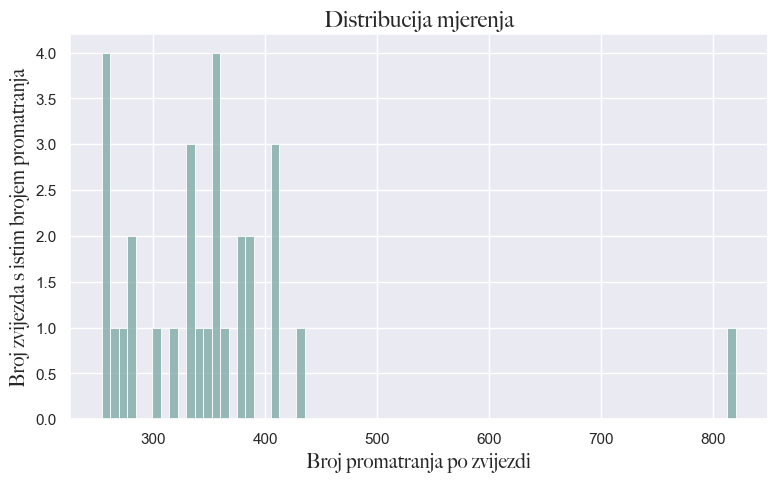

In [21]:
plt.figure(figsize=(9,5))
sns.histplot(data=lc_analysis_select['NdataZTF'].to_numpy(),color=turqoise, bins=75) # drawing a histogram of the distribution of measurements
plt.title('Distribucija mjerenja', fontproperties=font,fontsize=16)
plt.xlabel('Broj promatranja po zvijezdi', fontproperties=font, fontsize=14)
plt.ylabel('Broj zvijezda s istim brojem promatranja', fontproperties=font,fontsize=14)
plt.savefig('../images/ZTF_observations_distribution_rrlyrae.png', dpi=650)
plt.show()

Now, unfortunately, our numbers drop to 29 possible stars with more than 250 datapoints!

## Period distribution

In [49]:
LC_ANALYSIS.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_rms,L_chi2dof,L_chi2dofR,Lmean_rms,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,LCtype,IndicatorType,ChiType,BE_score
25,872620,0.549247,0.549248,0.5492,1.0000,282,0.079112,1.1,1.0,0.206811,...,1.8303,103.6269,0.0136,7.6183,0.22,0.00000,1,NaN,NaN,NaN
97,2041979,0.653694,0.653639,0.6537,0.9999,276,0.134647,1.5,1.2,0.137441,...,1.5347,207.4689,0.0144,9.8341,0.30,0.00008,1,NaN,NaN,NaN
98,2044369,0.534950,0.534950,0.5350,1.0000,253,0.095777,0.8,0.8,0.308125,...,1.8723,332.7787,0.0266,9.3489,0.15,0.00000,2,NaN,NaN,NaN
112,2227132,0.642661,0.642661,0.6427,1.0000,260,0.039765,2.2,1.0,0.117412,...,1.5916,28.1136,0.0191,10.9645,0.25,0.00000,2,NaN,NaN,NaN
119,2280940,0.562372,0.562374,0.5624,1.0000,310,0.120769,1.4,1.1,0.177601,...,1.7817,288.6003,0.0118,10.4442,0.23,0.00000,2,NaN,NaN,NaN


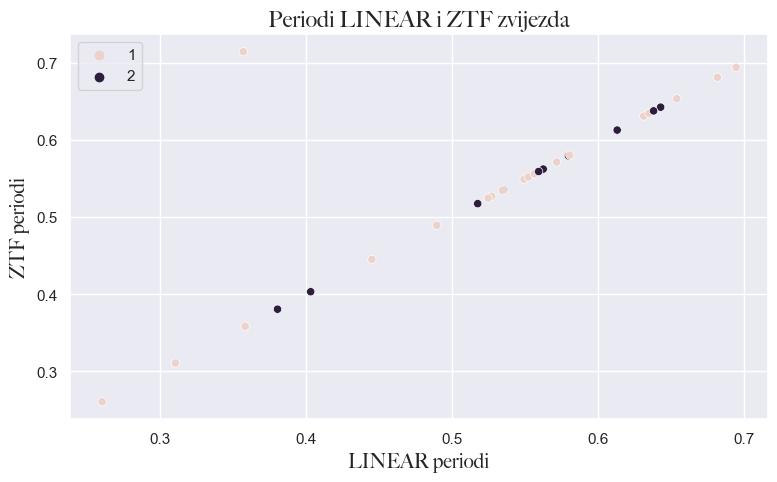

In [54]:
plt.figure(figsize=(9,5))
sns.scatterplot(data=LC_ANALYSIS, x='Plinear', y='Pztf', hue='LCtype', palette=muted_colors)
plt.title('Periodi LINEAR i ZTF zvijezda', fontproperties=font,fontsize=16)
plt.xlabel('LINEAR periodi', fontproperties=font, fontsize=14)
plt.ylabel('ZTF periodi', fontproperties=font,fontsize=14)
plt.savefig('../images/period_dist_linztf.png', dpi=650)
plt.legend()
plt.show()

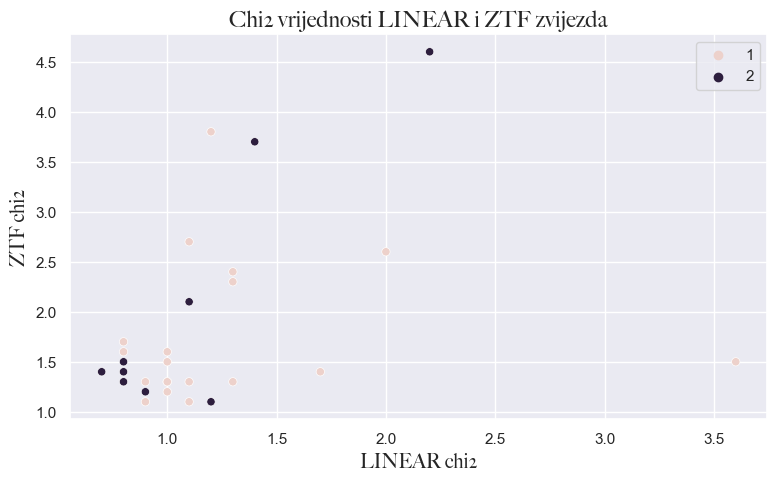

In [55]:
plt.figure(figsize=(9,5))
sns.scatterplot(data=LC_ANALYSIS, x='L_chi2dofR', y='Zchi2dofR', hue='LCtype', palette=muted_colors)
plt.title('Chi2 vrijednosti LINEAR i ZTF zvijezda', fontproperties=font,fontsize=16)
plt.xlabel('LINEAR chi2', fontproperties=font, fontsize=14)
plt.ylabel('ZTF chi2', fontproperties=font,fontsize=14)
plt.savefig('../images/chi2_dist_linztf.png', dpi=650)
plt.legend()
plt.show()

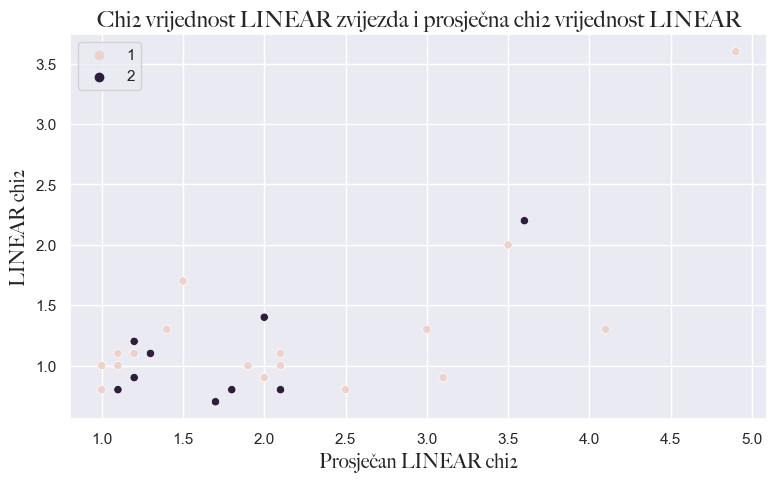

In [56]:
plt.figure(figsize=(9,5))
sns.scatterplot(data=LC_ANALYSIS, x='Lmean_chi2dofR', y='L_chi2dofR', hue='LCtype', palette=muted_colors)
plt.title('Chi2 vrijednost LINEAR zvijezda i prosječna chi2 vrijednost LINEAR', fontproperties=font,fontsize=16)
plt.xlabel('Prosječan LINEAR chi2', fontproperties=font, fontsize=14)
plt.ylabel('LINEAR chi2', fontproperties=font,fontsize=14)
plt.savefig('../images/chi2_dist_lin.png', dpi=650)
plt.legend()
plt.show()

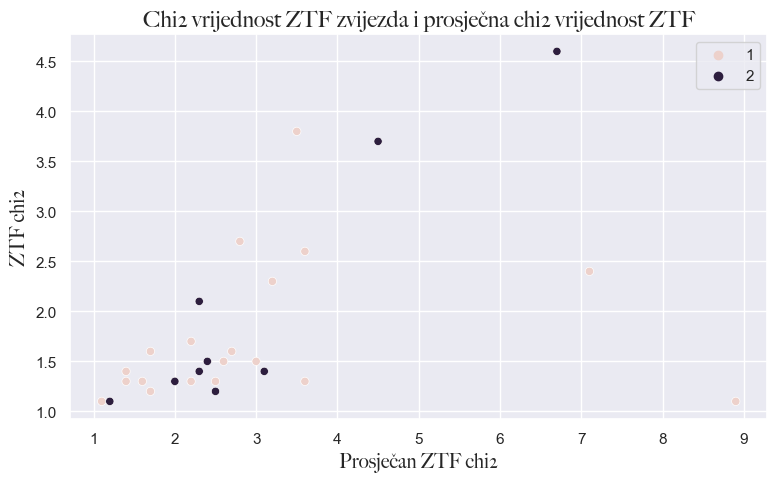

In [58]:
plt.figure(figsize=(9,5))
sns.scatterplot(data=LC_ANALYSIS, x='Zmean_chi2dofR', y='Zchi2dofR', hue='LCtype', palette=muted_colors)
plt.title('Chi2 vrijednost ZTF zvijezda i prosječna chi2 vrijednost ZTF', fontproperties=font,fontsize=16)
plt.xlabel('Prosječan ZTF chi2', fontproperties=font, fontsize=14)
plt.ylabel('ZTF chi2', fontproperties=font,fontsize=14)
plt.savefig('../images/chi2_dist_ztf.png', dpi=650)
plt.legend()
plt.show()

---

In [45]:
lc_counts = LC_ANALYSIS['LCtype'].value_counts().reset_index()
lc_counts.columns = ['LCtype', 'Count']

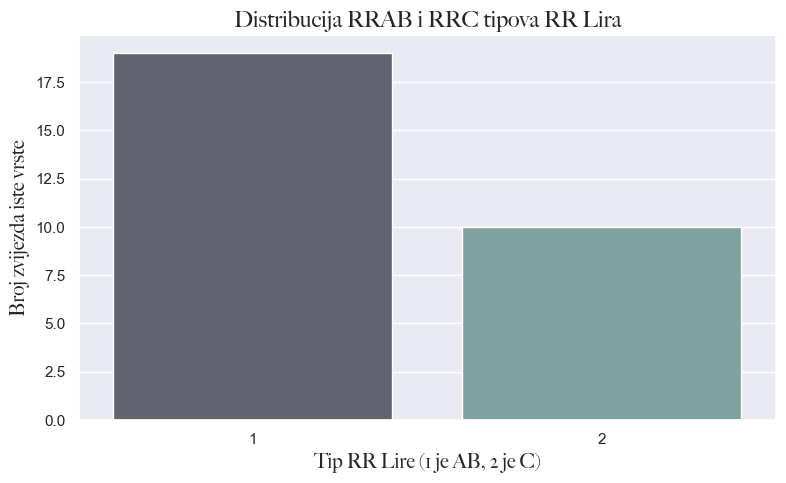

In [46]:
plt.figure(figsize=(9,5))   
sns.barplot(data=lc_counts, x='LCtype', y='Count', palette=muted_colors)
plt.title('Distribucija RRAB i RRC tipova RR Lira', fontproperties=font,fontsize=16)
plt.xlabel('Tip RR Lire (1 je AB, 2 je C)', fontproperties=font, fontsize=14)
plt.ylabel('Broj zvijezda iste vrste', fontproperties=font,fontsize=14)
plt.savefig('../images/RABC_distribution_rrlyrae.png', dpi=650)
plt.show()

In [48]:
p1 = round(lc_counts['Count'][0]/len(LC_ANALYSIS['LINEAR id']),4)*100
p2 = round(lc_counts['Count'][1]/len(LC_ANALYSIS['LINEAR id']), 4)*100
print(f'The percentage of RRAB stars is {p1}%, while for RRC stars it is {p2}% .')

The percentage of RRAB stars is 65.52%, while for RRC stars it is 34.48% .
